# **Support Vector Machines (SVM)**

Support Vector Machines, or SVMs, can often do better than others models at fitting data -- especially data is that is highly non-linear. SVM models use kernels to draw complex boundaries around sets like data points. The diagram on the left in the illustration below shows a 2D set of data points that a linear model will not fit. In other words, theres is no line you can draw to separate the blue points from the green points. However, SVM can use a "kernel trick" to add a third dimension to each data point based on its distance from the center. In 3D space (below right), you can then draw a plane that cleanly separates the twi classes of data points.

![](https://miro.medium.com/max/700/1*mCwnu5kXot6buL7jeIafqQ.png)

That's a simple way to visualize how Support Vector Machine works. Let's learn about SVM by using the "Labeled Faces in the Wild" dataset that is provided with scikit-learn to build a facial-recognition model.

## **Load the dataset**

The first step is to import facial images from the dataset. We'll set the minimum number of faces per person to 100, which means that only five sets of faces will be imported corresponding to five famous people.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
faces = fetch_lfw_people(min_faces_per_person=100)
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1.140 facial images were loaded. Each image measures 62 by 47 pixels for a total of 2.914 pixels per image. That basically means we're working with a model with 2.914 feature columns. That's a lot of columns! Let's check the balance in our dataset by generating a histogram showing how many facial images were imported for each of the five personalities.

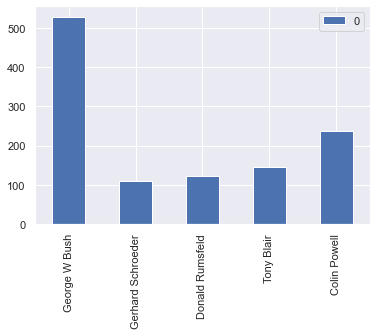

In [3]:
from collections import Counter

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar');

The dataset is not very well balanced, but we're not too concerned because the net effect will probably be that the model is better at recognizing certain people than others. Let's plot some of the facial images so we can see what they look like.

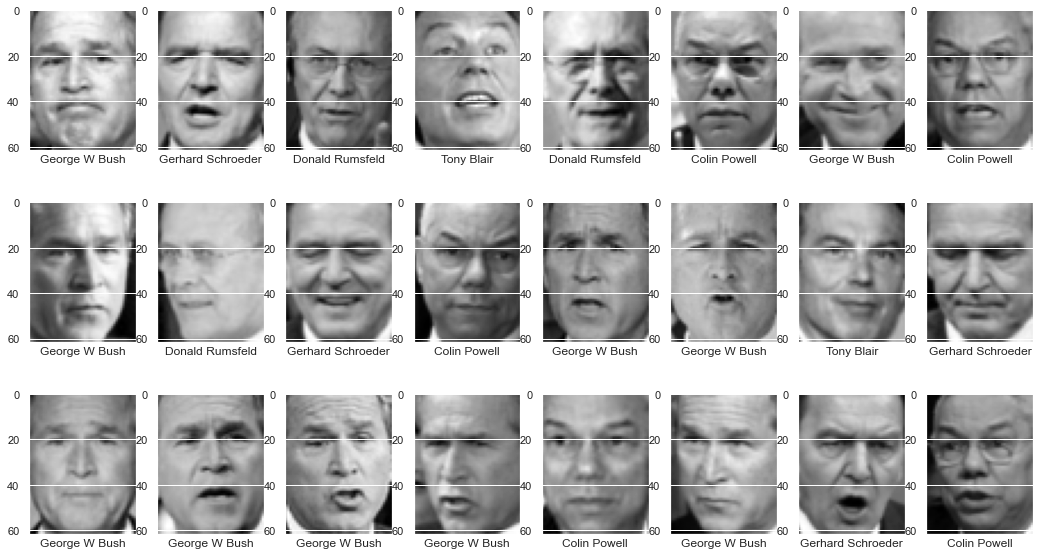

In [4]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], xlabel=faces.target_names[faces.target[i]])

## **Train an SVM model**

The next task is to train an SVM model to do image classification using the faces in our dataset. Let's start by splitting the dataset so 80% can be used for training and 20% for testing.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, train_size=0.8, random_state=42)

Now let's create an SVM classifier and train it using the 80% of the dataset reserved for training.

In [6]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced', gamma='auto')
model.fit(X_train, y_train)

SVC(class_weight='balanced', gamma='auto')

Next, let's use the 20% of the dataset aside for testing to assess the accuracy of the model.

In [7]:
model.score(X_test, y_test)

0.4649122807017544

That's not very encouraging. But we're far from done.

SVM can use several types of kernels to fit a mathematical model to a dataset. The default kernel type is one called *radial-basis function*, which scikit-learn abbreviates 'rbf'. You can specify the kernel type with the `SVC` function's `kernel` parameter. Other common values include `'linear'`, `'poly'`, and `'sigmoid'`. It could be that another kernel type would fit the data better. But there's something else that might help even more. That "something else" is PCA.

## **Apply Principal Component Analysis (PCA)**

It is possible  that using PCA to reduce the number of columns ("features") in our dataset will increase the accuracy of the model by reducing the amount of information in each facial image, effectively filtering out the "noise" of too much detail. A pleasant side effects that the model should train faster, too. Let's build a pipeline that performs a PCA transform on the input data, reducing 2.914 columns to 150, and uses SVM classifier to fit a model to the training data.

> **Pipelines** are a handy mechanism in scikit-learn for building complex models that transform input data before using it to train or predict.

In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(class_weight='balanced', gamma='auto')
model =make_pipeline(pca, svc)
model.fit(X_train, y_train)

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(class_weight='balanced', gamma='auto'))])

Now let's score the model again.

In [9]:
model.score(X_test, y_test)

0.9122807017543859

That's *much* better! Is it intuitive why using PCA to eliminate almost 95% of the data in each facial image increased the accuracy of the model? if no, try running the code below to visualize what the faces look like *after* they're PCAed. Then compare the resulting facial images to the ones above. Do you see the difference? *Now* is it obvious why PCA had such a dramatic effect on the model?

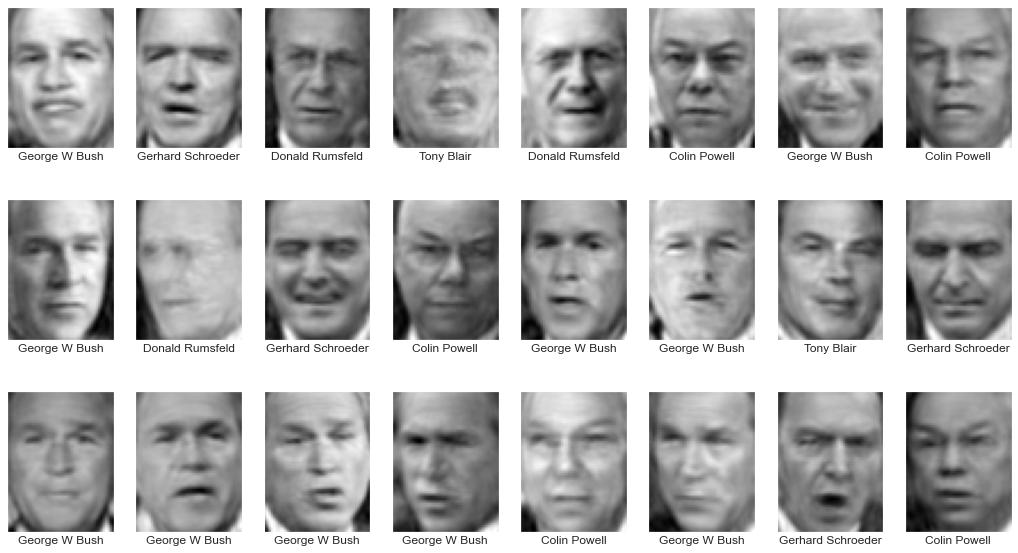

In [10]:
transformed = pca.transform(faces.data)
restored = pca.inverse_transform(transformed).reshape(1140, 62, 47)

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(restored[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Here's something else to consider. How is it possible that eliminating almost 95% of the data in a facial dataset retains enough information that you can still recognize the faces? And what does that tell you about PCA?

## **Tune the hyperparameters**

One way to find the optimum combination of parameters provided to learning algorithm in scikit-learn is to use `GridSearchCV`, which trains the model multiple times with all the different combinations of parameters that you specify. Let's use `GridSearchCV` to find the optimum values for the SVM's `C` and `gamma` parameters, which tend to have an important effect on SVM models. Note that training will take longer now because the model will be trained 16 times. (Good thing we reduced the number of dimensions with PCA!)

In [11]:
from sklearn.model_selection import GridSearchCV

params = {'svc__C': [1, 5, 10, 50],
          'svc__gamma': [0.001, 0.005, 0.010, 0.050]}

grid = GridSearchCV(model, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            svd_solver='randomized',
                                            whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            gamma='auto'))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.001, 0.005, 0.01, 0.05]})

Now let's find out what the optimum values for *C* and *gamma* are, and replace *model* with the optimized model.

In [12]:
print(grid.best_params_)
model = grid.best_estimator_

{'svc__C': 1, 'svc__gamma': 0.005}


Finally, let's see if the optimized ("hypertuned") model does a better job of recognizing  faces than our original model.

In [13]:
model.score(X_test, y_test)

0.9385964912280702

It appears that we improved the model's accuracy by about 2.5%. Let's print a classification assessment of the model's accuracy.

In [14]:
from sklearn.metrics import classification_report

y_predicted = model.predict(X_test)
print(classification_report(y_test, y_predicted, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.89      0.98      0.93        50
  Donald Rumsfeld       0.96      0.92      0.94        25
    George W Bush       0.98      0.94      0.96       106
Gerhard Schroeder       0.87      0.91      0.89        22
       Tony Blair       0.92      0.88      0.90        25

         accuracy                           0.94       228
        macro avg       0.92      0.93      0.92       228
     weighted avg       0.94      0.94      0.94       228



For clarity, let's generate a confusion matrix to see how the model *really* performed during testing.

Text(89.18, 0.5, 'Predicted label')

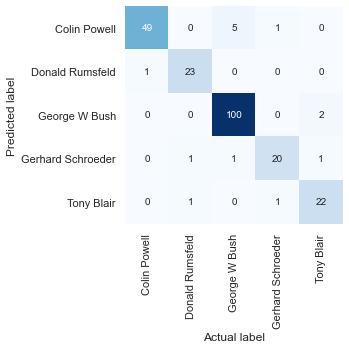

In [15]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel("Actual label")
plt.ylabel("Predicted label")

The model correctly identified Collin Powell 49 times out of 50, Donal Rumsfeld 23 times out of 25, and so on. That's not bad. And it's a great example of Support Vector Machine at work. It would be challenging, perhaps impossible, to do this well using more conventional learning algorithms such as logistic regression.

## **Cross-validate the model**

Currently, we are using a randomly selected 20% of the faces in the dataset to test the model and quantify its accuracy. Unfortunately, you can (and almost always will) get different results depending on which 20% of the dataset you select. For a more reliable measure of accuracy, you can cross-validate the model by training it several times, each time using different subsets of the original dataset for training and testing, and averaging the scores from each run. (This is precisely what GridSearchCV does when evaluating the effect of different parameter combinations.) Scikit's `cross_validate` function makes this easy. Let's finish up by using it to measure the accuracy of our model. We'll divide the original dataset into five folds and train the model five times, each time using a different fold for testing and the remaining folds for training.

In [16]:
from sklearn.model_selection import cross_validate

scores  = cross_validate(model, faces.data, faces.target, cv=5)
print(scores['test_score'].mean())

0.8850877192982456



The cross-validated score is lower than the score returned by the model's score method. That's OK, because the CV score is probably a more accurate indicator of how well the model will respond to faces it hasn't seen before. And to a data scientist, accuracy is everything.